In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [7]:
us_change = pd.read_csv("us_change.csv")

def parse_quarter(quarter_str):
    year, quarter = quarter_str.split(" ")
    month = (int(quarter[1]) - 1) * 3 + 1
    return pd.Timestamp(f"{year}-{month:02d}-01")

us_change["Quarter"] = us_change["Quarter"].apply(parse_quarter)

us_change.set_index("Quarter", inplace=True)

us_change.head()


,Consumption,Income,Production,Savings,Unemployment
Quarter,,,,,
1970-01-01,0.618566,1.044801,-2.452486,5.299014,0.9
1970-04-01,0.451984,1.225647,-0.551459,7.789894,0.5
1970-07-01,0.872872,1.585154,-0.358652,7.403984,0.5
1970-10-01,-0.271848,-0.239545,-2.185691,1.169898,0.7
1971-01-01,1.901345,1.975925,1.909764,3.535667,-0.1


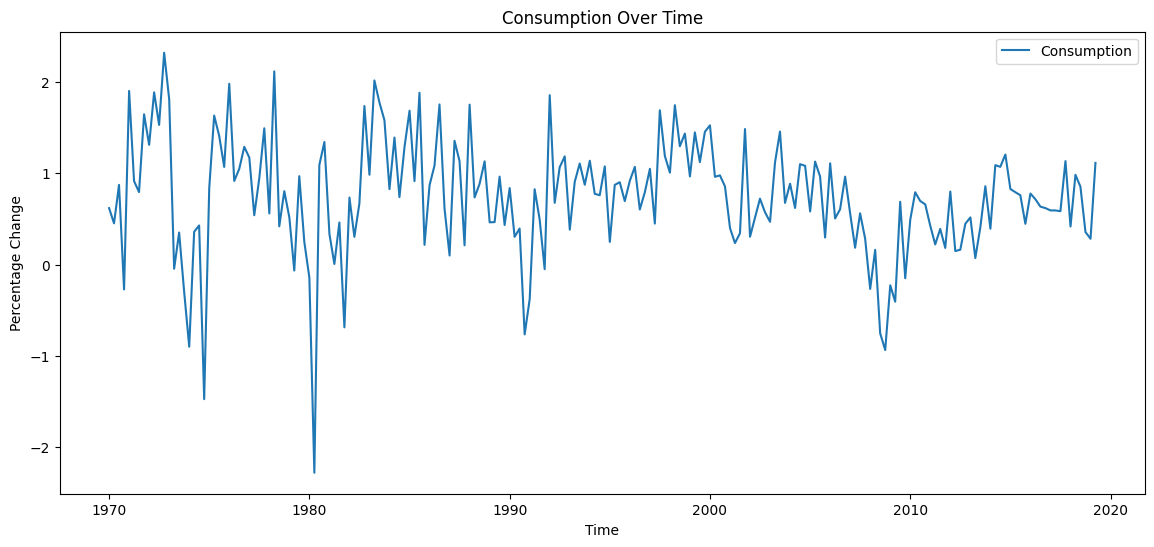

In [8]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=us_change["Consumption"], label="Consumption")
plt.title("Consumption Over Time")
plt.xlabel("Time")
plt.ylabel("Percentage Change")
plt.legend()
plt.show()


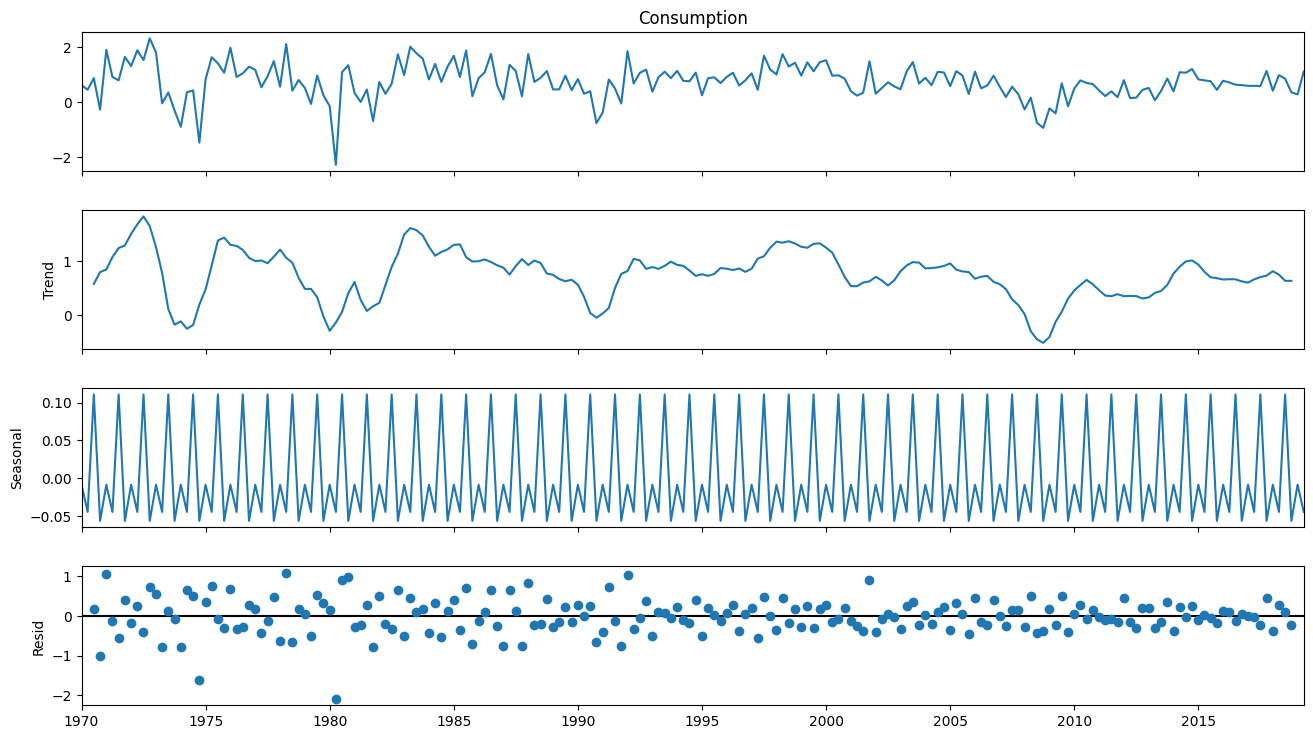

In [9]:
decomposition = seasonal_decompose(us_change["Consumption"], model="additive", period=4)
fig = decomposition.plot()
fig.set_size_inches(14, 8)
plt.show()


In [10]:
y = us_change["Consumption"]
X = us_change.drop(columns=["Consumption"])

X_train = X.iloc[:-12]
X_test = X.iloc[-12:]
y_train = y.iloc[:-12]
y_test = y.iloc[-12:]

In [11]:
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train_const).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            Consumption   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     150.6
Date:                Tue, 26 Nov 2024   Prob (F-statistic):           1.80e-56
Time:                        11:09:11   Log-Likelihood:                -48.277
No. Observations:                 186   AIC:                             106.6
Df Residuals:                     181   BIC:                             122.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2608      0.036      7.229   

In [12]:
y_pred = model.predict(X_test_const)

predictions_lr = pd.DataFrame({
    "Linear Regression": y_pred
}, index=y_test.index)

In [13]:
fitted_values_lr = pd.Series(model.fittedvalues, index=y_train.index)

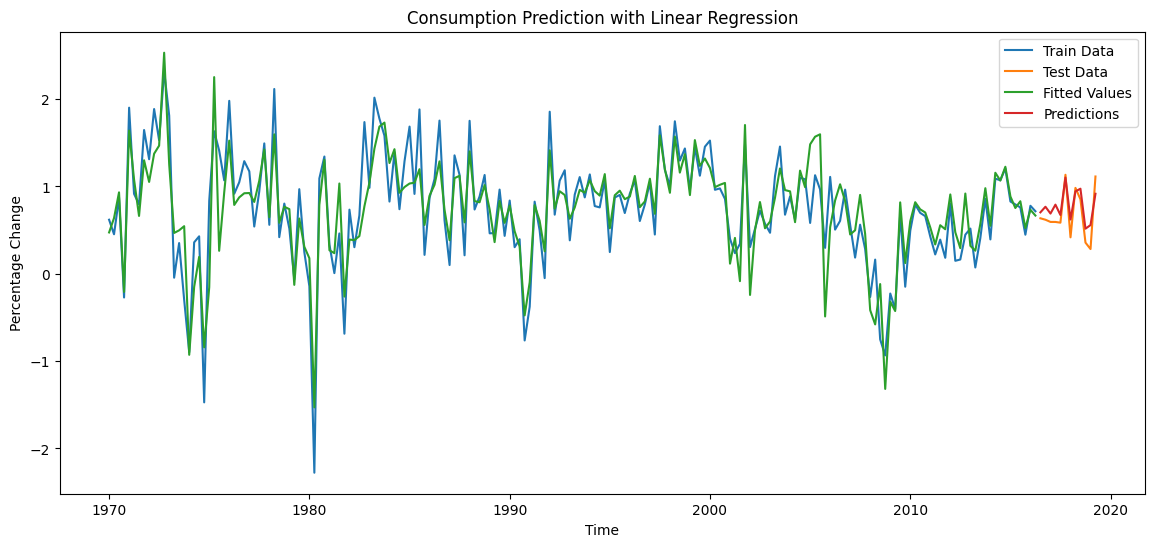

In [14]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=y_train, label="Train Data")
sns.lineplot(data=y_test, label="Test Data")
sns.lineplot(data=fitted_values_lr, label="Fitted Values")
sns.lineplot(data=predictions_lr["Linear Regression"], label="Predictions")
plt.title("Consumption Prediction with Linear Regression")
plt.xlabel("Time")
plt.ylabel("Percentage Change")
plt.legend()
plt.show()

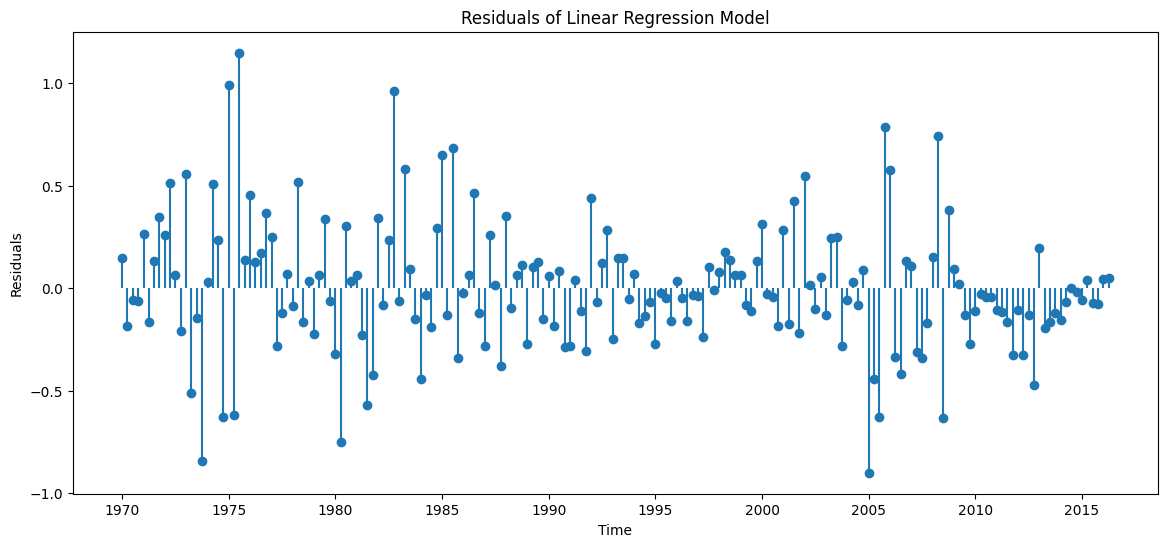

In [15]:
residuals_lr = y_train - fitted_values_lr

plt.figure(figsize=(14, 6))
plt.stem(residuals_lr.index, residuals_lr.values, basefmt=" ")
plt.title("Residuals of Linear Regression Model")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.show()

In [16]:
ljung_box_lr = acorr_ljungbox(residuals_lr, lags=[10], return_df=True)

print("Ljung-Box Test for Linear Regression Model:")
print(ljung_box_lr)

Ljung-Box Test for Linear Regression Model:
      lb_stat  lb_pvalue
10  18.032228   0.054422


In [18]:
def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

results_lr = {
    "MAE": mae(y_test, y_pred),
    "MSE": mse(y_test, y_pred),
    "RMSE": rmse(y_test, y_pred),
    "MAPE": mape(y_test, y_pred),
    "SMAPE": smape(y_test, y_pred),
    "R2": r2(y_test, y_pred)
}

results_df_lr = pd.DataFrame(results_lr, index=["Linear Regression"])
results_df_lr

,MAE,MSE,RMSE,MAPE,SMAPE,R2
Linear Regression,0.135545,0.023449,0.153129,27.39384,22.503201,0.679011
